# Ejercicio 1
Implemente las estructuras de datos y algoritmos básicos para la solución de un problema mediante algoritmos genéticos. Pruebe estas rutinas y compare los resultados con un método de gradiente descendiente para buscar el mínimo global de las siguientes funciones:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import string
import random
import time

## Funciones a utilizar

In [88]:
def bin2dec(b):
    '''
    función que transforma un número binario a decimal teniendo
    en cuenta la codificación usada
    '''
    # compongo el número teniendo en cuenta que el primer
    # bit es para el signo y que los 4 últimos son la parte decimal
    d = int(b[1:-4], 2) + 0.1 * int(b[-4:], 2)
    
    if b[0] == '1':
        # si hay un 1 delante, es negativo
        return -d
    else:
        # si hay un 0 delante, es positivo
        return d

def decode(pob):
    '''
    función que, dada una población, retorna la misma en decimales
    '''
    pob_real = []
    for i in range(len(pob)):
        pob_real.append(bin2dec(pob[i]))
    return pob_real

def initialize(n_ind, bits, f):
    '''
    función que inicializa la población dada una cantidad de individuos,
    bits para la parte entera y una función de codificación

    n_ind: cantidad de individuos
    bits: cantidad de bits para el entero
    f: función de codificación
    '''

    poblation = []
    for i in range(n_ind):
        poblation.append(f(bits))
    return poblation

def pob_evaluation(p, f, f_max = 0):
    '''
    función que dada una población y la función asociada al problema
    la evalúa y retorna el fitness asociado a cada individuo de la población.
    '''
    pob_fitness = []
    for ind in p:
        # el fitness se evalúa como 1 / f(x) + f_max ya que buscamos
        # el máximo fitness para el mínimo de una función
        f_actual = 1 / (f(ind) + f_max)
        pob_fitness.append(f_actual)
    return pob_fitness

def roullete_wheel_selection(p_fitness, p):
    '''
    método de selección de un padre usando la ruleta
    '''
    p_sum = sum(p_fitness)
    selection_probs = [f/p_sum for f in p_fitness]
    return np.random.choice(len(p), p = selection_probs)

def window_selection(pob_fitness):
    '''
    método de selección de un padre usando ventanas
    '''
    winners=np.zeros(len(pob_fitness))
    window = np.argsort(pob_fitness)
    window = window[::-1]
    
    for i in range(window.shape[0]):
        selected_pob=np.random.choice(window)
        winners[selected_pob]+=1
        # print(winners,window)
        window = window[:-1]
    goat=np.argmax(winners)  
    # print(f'idx={goat}  fitness={pob_fitness[goat]}')  
    return goat

def turnament_selection(pub_fitness, k):
    '''
    método de selección de padres usando torneos
    '''

    pub=np.arange(len(pub_fitness))
    # print(pub)
    selected=[]
    #elige a los 2 contrincantes team1 y team2
    for i in range(k):
        selected.append(np.random.choice(pub))
        pub=np.delete(pub,np.searchsorted(pub,selected[i]))
    pub_max=0
    # print(selected)
    for i in selected:
        # print(i,pub_fitness[i])
        if(pub_fitness[i]>pub_max):
            pub_max=pub_fitness[i]
            winner=i
    return winner
    
def select_best(fitness_p, p):
    '''
    devuelve los dos mejores individuos para realizar elitismo
    '''
    idx_1 = np.argmax(fitness_p)
    fitness_p[idx_1] = -1
    idx_2 = np.argmax(fitness_p)
    return p[idx_1], p[idx_2]
    

def cruza(pob, punto_cruza, prob_cruza, pob_fitness):
    '''
    función que realiza la cruza de una población
    dada una cierta probabilidad de que se realice
    y un punto de cruza a partir del cual se realiza
    '''
    # inicializo la nueva población
    prox_pob = []

    # se seleccionan los dos mejores para pasarlos a la siguiente generación
    a, b = select_best(pob_fitness, pob)

    # ELITISMO: se añaden los dos mejores a la siguiente población
    prox_pob.append(a)
    prox_pob.append(b)

    # repito n_ind/2 - 1 veces elección de 2 padres y realización de la cruza (o no)
    n_cruzas = int(len(pob)/2) - 1
    for i in range(n_cruzas):
        padre = pob[2 * i]
        madre = pob[2 * i + 1]
        # elijo un rand entre 0 y 1
        c_cruza = np.random.rand()
        if c_cruza < prob_cruza:
            # se realiza la cruza: tomo desde el punto de cruza hasta la cantidad de bits
            # que considero para la parte entera
            hijo1 = padre[0 : punto_cruza] + madre[punto_cruza:]
            hijo2 = madre[0 : punto_cruza] + padre[punto_cruza:]
            # print(f'padre: {pob[i]} - madre: {pob[i+1]} - hijo1: {hijo1} - hijo 2: {hijo2}')
            prox_pob.append(hijo1)
            prox_pob.append(hijo2)
            # print('se hizo la cruza')
        else:
            # se mantienen los padres en la nueva población
            prox_pob.append(padre)
            prox_pob.append(madre)
            
    return prox_pob

def mutacion(prox_pob, prob_mutacion, n_bits_int):
    '''
    función que realiza la mutación de los cromosomas dada una cierta
    probabilidad de que se realice, y teniendo en cuenta la cantidad de bits
    en la parte entera.
    Retorna la próxima población mutada.
    '''
    for i, ind in enumerate(prox_pob):
        # elijo un rand entre 0 y 1
        c_mutacion = np.random.rand()
        # print('cromosoma sin mutar', ind)
        if c_mutacion < prob_mutacion:
            # se realiza la mutación teniendo en cuenta que se hace en los bits de los enteros
            pos_mutacion = 1 + np.random.choice(n_bits_int)
            l_ind = list(ind)
            if l_ind[pos_mutacion] == '0':
                l_ind[pos_mutacion] = '1'
            else:
                l_ind[pos_mutacion] = '0'
            ind = ''.join(l_ind)
            # print('cromosoma mutado', ind)
        prox_pob[i] = ind
    return prox_pob


# MÉTODO DEL GRADIENTE

def grad_desc(l_inf, l_sup, alpha, n_iteraciones, f, grad_f):
    x_inicial = np.random.randint(l_inf, l_sup)
    # print(f'x inicial: {x_inicial}')

    x = x_inicial

    for i in range(n_iteraciones):

        # Calcular gradiente
        gradiente = grad_f(x)

        # Actualizar "x" usando gradiente descendente
        x = x - alpha*gradiente
        
    print(f'Mínimo encontrado por gradiente descendente en ({x},{f(x)})')

## Función 1
 $ f(x) = - x \sin(\sqrt{|x|}) $, con $ x \in [-512...512] $

Podemos considerar la codificación de un número decimal entre -512 y 512 teniendo en cuenta reales con un cromosoma de 14 genes, de la siguiente manera:

1 bit para el signo (0 para negativos, 1 para positivos)

9 bits para representar los enteros

4 bits para representar los decimales

### Funciones particulares y gráfico

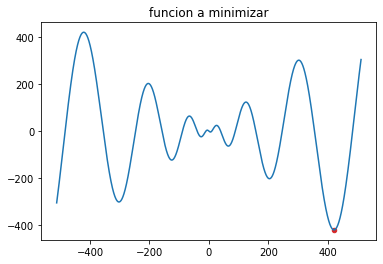

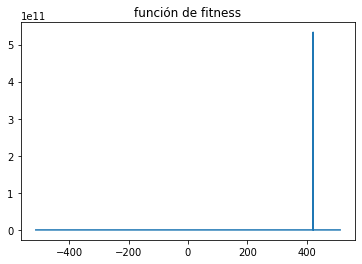

In [50]:
# ------------------------------ FUNCIONES PARTICULARES ---------------------------------

def generate_bin_f1(n_bits):
    # n_bits = cantidad de bits para la parte entera considerando 1 para el signo

    # elijo al azar una cadena de digitos en [0,1] para generar los cromosomas aleatorios
    source = string.digits[:2]
    chrom = ''.join((random.choice(source) for i in range(n_bits + 4)))
    for s in chrom:
        # si los bits designados para la parte decimal (4) son mayores que 9 se consideran 9
        if int(chrom[-4:],2) > 9:
            chrom = chrom[:-4] + '1001'
    return chrom
    
def func_1 (x):
    f_x = - x * np.sin(np.sqrt(abs(x)))
    return f_x

def grad_f1(x):
    grad = - np.sin(np.sqrt(abs(x))) - (x**2 * np.cos(np.sqrt(abs(x))))/(2*abs(x)*np.sqrt(abs(x)))
    return grad

# -----------------------------------  GRÁFICOS  ---------------------------------------

%matplotlib inline

plt.close('all')
x = np.arange(-512, 512, 0.1)
y1 = func_1(x)
plt.figure()
min=np.argmin(y1)
plt.scatter(x[min], y1[min], s=20, c='C3')

plt.plot(x, y1), plt.title('funcion a minimizar')

a = np.max(y1) # uso esto para hacer que la f de fitness de valores positivos
plt.figure()
plt.plot(x, 1 / (func_1(x)  + a)), plt.title('función de fitness')
plt.show()

### Resolución

In [68]:
# ----------------------------------- ALGORITMO GENÉTICO -----------------------------------------

print(f'Mínimo a encontrar: ({x[np.argmin(y1)]}, {np.min(y1)})')
print('')

tic = time.time()

# inicializo la población
n_ind = 10                          # cantidad de individuos
n_bits = 10                         # cantidad de bits para la parte entera

# criterios de finalización
gen_max = 10000                     # cantidad maxima de generaciones
n_estab = 60                        # cantidad de iteraciones para considerar una solución estable

# otros parámetros
prob_cruza = 0.7                    # probabilidad de cruza
prob_mutacion = 0.1                 # probabilidad de mutación
punto_cruza = int(0.7 * n_bits)     # a partir de donde cruzo

# Inicialización
pob = initialize(n_ind, n_bits, generate_bin_f1)

# decodificación a reales para poder evaluar la f de fitness
pob_real = decode(pob)

# evaluación inicial
# positivizo la función sumandole el máximo a los valores
max_f = a
pob_fitness = pob_evaluation(pob_real, func_1, max_f)
fitness_best_ind = np.max(pob_fitness)
# print('fitness máximo de la generación 0', fitness_best_ind)

n_gen = 0
c_estabilidad = 0
while(n_gen < gen_max - 1 and c_estabilidad < n_estab):

    # Selección de padres: elijo n_ind padres con el metodo elegido
    prog_idx = []
    for i in range (n_ind):

        # ---------------------- ACÁ SE CAMBIA EL MÉTODO DE SELECCIÓN --------------------------
        
        prog_idx.append(roullete_wheel_selection(pob_fitness, pob_real))
        # prog_idx.append(window_selection(pob_fitness))
        # prog_idx.append(turnament_selection(pob_fitness, k = 4))
    
    # Cruza
    prox_pob = cruza(pob, punto_cruza, prob_cruza, pob_fitness)

    # Mutación
    prox_pob = mutacion(prox_pob, prob_mutacion, n_bits)

    # Se evalúa la nueva población
    pob = prox_pob
    # decodificación a reales para poder evaluar la f de fitness
    
    pob_real = decode(pob)
    pob_fitness = pob_evaluation(pob_real, func_1, a)

    # busco el mejor individuo de la población

    fitness_best_ind_ = fitness_best_ind
    fitness_best_ind = np.max(pob_fitness)
    
    if np.isclose(fitness_best_ind, fitness_best_ind_):
        # si el anterior mejor fitness está cerca del nuevo, aumento el contador
        c_estabilidad += 1
    else:
        c_estabilidad = 0
    # print(f'fitness máximo de la generación {n_gen + 1}: {fitness_best_ind}')
    n_gen += 1

toc = time.time()

# print(f'finalizó en la generación {n_gen+1}')
print('--------------------- Algoritmo genético -------------------------------')
print(f'Mínimo encontrado en la generación {n_gen+1}: {pob_real[np.argmax(pob_fitness)], 1 / np.max(pob_fitness) - a}')
print(f'Tiempo empleado: {toc - tic} s')
# ----------------------------------- GRADIENTE DESCENDENTE -----------------------------------------
tic = time.time()
print(' ')
print('--------------------- Gradiente descendente ----------------------------')
grad_desc(-512, 512, 0.3, 300, func_1, grad_f1)
toc = time.time()
print(f'Tiempo empleado: {toc - tic} s')

Mínimo a encontrar: (421.00000000021214, -418.9827640161426)

--------------------- Algoritmo genético -------------------------------
Mínimo encontrado en la generación 73: (420.9, -418.9822909371578)
Tiempo empleado: 0.03472089767456055 s
 
--------------------- Gradiente descendente ----------------------------
Mínimo encontrado por gradiente descendente en (5.239199300195521,-3.945301625284325)
Tiempo empleado: 0.003052234649658203 s


## Función 2

$ f(x) = x + 5 \sin(3x) + 8 \cos (5 x)$, con $x \in \mathbb R $ en el intervalo $[0...20]$

$ \nabla f(x) = 1+15\cos \left(3x\right)-40\sin \left(5x\right) $

1 bit para el signo (siempre es 0)

5 bits para la parte entera

4 bits para el decimal


### Funciones particulares y gráfico

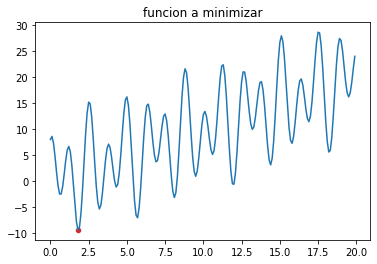

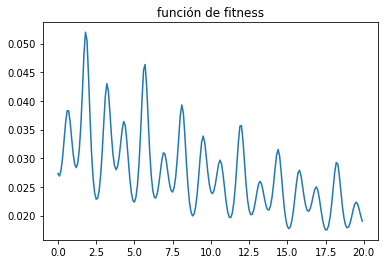

In [70]:
# ------------------------------ FUNCIONES PARTICULARES ---------------------------------
def func_2 (x):
    f_x = x + 5 * np.sin(3 * x) + 8 * np.cos(5 * x)
    return f_x

def grad_f2(x):
    return 1 + 15*np.cos(3*x) - 40 * np.sin(5*x)

def generate_bin_f2(n_bits):
    # n_bits = cantidad de bits para la parte entera considerando 1 para el signo

    # elijo al azar una cadena de digitos en [0,1] para generar los cromosomas aleatorios
    source = string.digits[:2]
    chrom = ''.join((random.choice(source) for i in range(n_bits - 1 + 4)))
    for s in chrom:
        # si los bits designados para la parte decimal (4) son mayores que 9 se consideran 9
        if int(chrom[-4:],2) > 9:
            chrom = chrom[:-4] + '1001'
        if int(chrom[:-4],2) > 20:
        # si los bits designados para la parte entera (5) son mayores que 20 se consideran 20
            chrom = '10011' + chrom[-4:]
    # en este caso siempre el primer bit es 0
    chrom = '0' + chrom
    return chrom

# -------------------------------------- GRÁFICOS -------------------------------------------

plt.close('all')
x = np.arange(-0, 20, 0.1)
y2 = func_2(x)
plt.figure()
min=np.argmin(y2)
plt.plot(x, y2), plt.title('funcion a minimizar')
plt.scatter(x[min], y2[min], s=20, c='C3')

a = np.max(y2) # uso esto para hacer que la f de fitness de valores positivos
plt.figure()
plt.plot(x, 1 / (func_2(x)  + a)), plt.title('función de fitness')
plt.show()

### Resolución

In [99]:
print(f'Mínimo a encontrar: ({x[np.argmin(y2)]}, {np.min(y2)})')
print('')
tic = time.time()

# ------------------------------ ALGORITMO GENÉTICO ---------------------------------

# inicializo la población
n_ind = 10                          # cantidad de individuos
n_bits = 6                          # cantidad de bits para la parte entera (con el signo)

# criterios de finalización
gen_max = 10000                     # cantidad maxima de generaciones
n_estab = 100                        # cantidad de iteraciones para considerar una solución estable

# otros parámetros
prob_cruza = 0.8                    # probabilidad de cruza
prob_mutacion = 0.1                 # probabilidad de mutación
punto_cruza = int(0.7 * n_bits)     # a partir de donde cruzo

# Inicialización
pob = initialize(n_ind, n_bits, generate_bin_f2)

# decodificación a reales para poder evaluar la f de fitness
pob_real = decode(pob)

# evaluación inicial
# positivizo la función sumandole el máximo a los valores
max_f = a
pob_fitness = pob_evaluation(pob_real, func_2, max_f)
fitness_best_ind = np.max(pob_fitness)
# print('fitness máximo de la generación 0', fitness_best_ind)

n_gen = 0
c_estabilidad = 0
while(n_gen < gen_max - 1 and c_estabilidad < n_estab):
    # Selección de padres: elijo n_ind padres con el metodo elegido
    prog_idx = []
    for i in range (n_ind):
        # prog_idx.append(roullete_wheel_selection(pob_fitness, pob_real))
        prog_idx.append(window_selection(pob_fitness))
        # prog_idx.append(turnament_selection(pob_fitness, k = 10))
    
    # Cruza
    prox_pob = cruza(pob, punto_cruza, prob_cruza, pob_fitness)

    # Mutación
    prox_pob = mutacion(prox_pob, prob_mutacion, n_bits)

    # Se evalúa la nueva población
    pob = prox_pob
    # decodificación a reales para poder evaluar la f de fitness
    
    pob_real = decode(pob)
    pob_fitness = pob_evaluation(pob_real, func_2, a)
    # busco el mejor individuo de la población
    fitness_best_ind_ = fitness_best_ind
    fitness_best_ind = np.max(pob_fitness)
    if np.isclose(fitness_best_ind, fitness_best_ind_):
        # si el anterior mejor fitness está cerca del nuevo, aumento el contador
        c_estabilidad += 1
    else:
        c_estabilidad = 0
    # print(f'fitness máximo de la generación {n_gen + 1}: {fitness_best_ind}')
    n_gen += 1

toc = time.time()

# print(f'finalizó en la generación {n_gen+1}')
print('--------------------- Algoritmo genético -------------------------------')
print(f'Mínimo encontrado en la generación {n_gen+1}: {pob_real[np.argmax(pob_fitness)], 1 / np.max(pob_fitness) - a}')
print(f'Tiempo empleado: {toc - tic} s')

# ----------------------------------- GRADIENTE DESCENDENTE -----------------------------------------
tic = time.time()
print(' ')
print('--------------------- Gradiente descendente ----------------------------')
grad_desc(0, 20, 0.01, 20, func_2, grad_f2)
toc = time.time()
print(f'Tiempo empleado: {toc - tic} s')

Mínimo a encontrar: (1.8, -9.352864532857351)

--------------------- Algoritmo genético -------------------------------
Mínimo encontrado en la generación 103: (1.8, -9.352864532857353)
Tiempo empleado: 0.12484622001647949 s
 
--------------------- Gradiente descendente ----------------------------
Mínimo encontrado por gradiente descendente en (14.218488638171102,6.202576592419044)
Tiempo empleado: 0.0 s


## Función 3
$ f(x, y) = (x^2 + y^2)^{0.25} [\sin^2 (50 (x^2 + y^2)^{0.1}) + 1]$, con $x, y \in [-100...100]$



1 bit para el signo

7 bits para la parte entera

4 bits para los decimales

### Funciones particulares y gráficos

In [2]:
# ------------------------------ FUNCIONES PARTICULARES ---------------------------------

def func_3 (x, y):
    a = x ** 2 + y ** 2
    f_x = np.power(a, 0.25) * (np.sin(50 * np.power(a, 0.1)) ** 2  + 1)
    return f_x

def generate_bin_f3(n_bits):
    # n_bits = cantidad de bits para la parte entera considerando 1 para el signo

    # elijo al azar una cadena de digitos en [0,1] para generar los cromosomas aleatorios
    source = string.digits[:2]
    chrom = ''.join((random.choice(source) for i in range(n_bits + 4)))
    for s in chrom:
        # si los bits designados para la parte decimal (4) son mayores que 9 se consideran 9
        if int(chrom[-4:],2) > 9:
            chrom = chrom[:-4] + '1001'
        if int(chrom[:-4],2) > 99:
        # si los bits designados para la parte entera (7) son mayores que 99 se consideran 99
            chrom = '1100011' + chrom[-4:]
    return chrom

def initialize_f3(n_ind, bits, f):
    # n_ind: cantidad de individuos
    # bits: cantidad de bits para el entero
    poblation = []
    for i in range(n_ind):
        # Acá se concatena el X con el Y
        poblation.append(f(bits) + f(bits))
    return poblation

def divide_chrom(pob):
    vec_x = []
    vec_y = []
    for ind in pob:
        l_ind = list(ind)
        x = l_ind[:12]
        y = l_ind[12:]
        x = ''.join(x)
        y = ''.join(y)
        vec_x.append(x)
        vec_y.append(y)
    return vec_x, vec_y

def pob_evaluation_f3(p_x, p_y, f_max = 0):
    pob_fitness = []
    mejor_pos = 0
    for i in range(len(p_x)):
        # el fitness se evalúa como 1 / f(x) + f_max ya que buscamos el máximo fitness para el mínimo de una función
        f_actual = 1 / (func_3(p_x[i], p_y[i]) + f_max)
        pob_fitness.append(f_actual)
    return pob_fitness

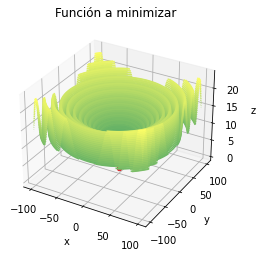

In [3]:
# ------------------------------ GRÁFICOS ---------------------------------

x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)

X, Y = np.meshgrid(x, y)
Z = func_3(X, Y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='summer')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Función a minimizar')
min = np.argmin(func_3(x, y))
ax.scatter(x[min], y[min], np.min(Z), c='C3')
plt.show()

### Resolución

In [107]:
print(f'Mínimo a encontrar: ({x[min]}, {y[min]}, {np.min(Z)})')
print('')
tic = time.time()
# inicializo la población
n_ind = 1000                          # cantidad de individuos
n_bits = 8                          # cantidad de bits para la parte entera (con el signo)

# criterios de finalización
gen_max = 10000                     # cantidad maxima de generaciones
n_estab = 60                        # cantidad de iteraciones para considerar una solución estable

# otros parámetros
prob_cruza = 0.8                    # probabilidad de cruza
prob_mutacion = 0.1                 # probabilidad de mutación
punto_cruza = int(0.7 * n_bits)     # a partir de donde cruzo

# Inicialización
pob = initialize_f3(n_ind, n_bits, generate_bin_f3)
# print(pob)

pob_x, pob_y = divide_chrom(pob)

# decodificación a reales para poder evaluar la f de fitness - Se separa la x de la y
pob_real_x = decode(pob_x)
pob_real_y = decode(pob_y)

# evaluación inicial
# positivizo la función sumandole el máximo a los valores
max_f = a
pob_fitness = pob_evaluation_f3(pob_real_x, pob_real_y, max_f)
fitness_best_ind = np.max(pob_fitness)
# print('fitness máximo de la generación 0', fitness_best_ind)

n_gen = 0
c_estabilidad = 0
while(n_gen < gen_max - 1 and c_estabilidad < n_estab):

    # Selección de padres: elijo n_ind padres con el metodo elegido
    prog_idx = []
    for i in range (n_ind):
        # prog_idx.append(roullete_wheel_selection(pob_fitness, pob_real_x))
        # prog_idx.append(window_selection(pob_fitness))
        prog_idx.append(turnament_selection(pob_fitness, k = 10))
    
    # Cruza
    prox_pob_x = cruza(pob_x, punto_cruza, prob_cruza, pob_fitness)
    prox_pob_y = cruza(pob_y, punto_cruza, prob_cruza, pob_fitness)

    # Mutación
    prox_pob_x = mutacion(prox_pob_x, prob_mutacion, n_bits)
    prox_pob_y = mutacion(prox_pob_y, prob_mutacion, n_bits)

    # decodificación a reales para poder evaluar la f de fitness
    pob_real_x = decode(prox_pob_x)
    pob_real_y = decode(prox_pob_y)

    pob_fitness = pob_evaluation_f3(pob_real_x, pob_real_y, max_f)
    
    # busco el mejor individuo de la población
    fitness_best_ind_ = fitness_best_ind
    fitness_best_ind = np.max(pob_fitness)
    
    if np.isclose(fitness_best_ind, fitness_best_ind_):
        # si el anterior mejor fitness está cerca del nuevo, aumento el contador
        c_estabilidad += 1
    else:
        c_estabilidad = 0
    # print(f'fitness máximo de la generación {n_gen + 1}: {fitness_best_ind}')
    n_gen += 1

toc = time.time()

print('--------------------- Algoritmo genético -------------------------------')
print(f'mínimo encontrado en la generación {n_gen+1}: ({pob_real_x[np.argmax(pob_fitness)]}, {pob_real_y[np.argmax(pob_fitness)]}, {1 / np.max(pob_fitness) - a})')
print(f'Tiempo empleado: {toc - tic} s')


Mínimo a encontrar: (0.10010010010010717, 0.10010010010010717, 0.5467853625415365)
finalizó en la generación 10000
mínimo encontrado en la generación 10000: (-6.9, -3.9, 2.983194356284706)


## Implementación de método del gradiente descendente

Para implementarlo necesitamos de
1. gradiente de la función a minimizar
2. número de iteraciones
3. tasa de aprendizaje $\alpha$

Luego aplicamos la fórmula
$ x_{t+1} = x_{t}  - \alpha \nabla f$

In [8]:
def grad_desc_f3(l_inf, l_sup, alpha, n_iteraciones, f, grad_fx, grad_fy):

    v_x = np.random.randint(l_inf, l_sup)
    v_y = np.random.randint(l_inf, l_sup)

    for i in range(n_iteraciones):
        # Actualizar "x" usando gradiente descendente
        a = grad_fx.subs(x, v_x)
        grad1 = a.subs(y, v_y)
        v_x = v_x - alpha*grad1

        # Actualizar "y" usando el gradiente descendente
        b = grad_fy.subs(x, v_x)
        grad2 = b.subs(y, v_y)
        v_y = v_y - alpha*grad2

    # evaluamos la x encontrada
    y_ = f.subs(x, v_x)
    res = y_.subs(y, v_y) 
    print(f'Mínimo encontrado por gradiente descendente en ({v_x}, {v_y} ,{res})')

In [9]:
import sympy as sp
x, y = sp.symbols('x y')
a = x ** 2 + y ** 2
f3 = np.power(a, 0.25) * (sp.sin(50 * np.power(a, 0.1)) ** 2  + 1)

# gradiente
grad_f3x = sp.diff(f3, x)
grad_f3y = sp.diff(f3, y)

# ----------------------------------- GRADIENTE DESCENDENTE -----------------------------------------
tic = time.time()
print(' ')
print('--------------------- Gradiente descendente ----------------------------')
grad_desc_f3(0, 100, 0.01, 20, f3, grad_f3x, grad_f3y)
toc = time.time()
print(f'Tiempo empleado: {toc - tic} s')

 
--------------------- Gradiente descendente ----------------------------
Mínimo encontrado por gradiente descendente en (86.4286357841105, 44.2196658137158 ,15.0275606127720)
Tiempo empleado: 0.371734619140625 s
